In [1]:
from planning_through_contact.geometry.planar.planar_pushing_trajectory import PlanarPushingContactMode, PlanarPushingTrajectory
from planning_through_contact.simulation.controllers.hybrid_mpc import HybridMpcConfig
from planning_through_contact.simulation.dynamics.slider_pusher.slider_pusher_system import SliderPusherSystem
# from planning_through_contact.simulation.systems.slider_pusher_trajectory_feeder import SliderPusherTrajSegment
import numpy as np
import matplotlib.pyplot as plt

traj = PlanarPushingTrajectory.load("../../trajectories/box_pushing_demos/hw_demo_C_1.pkl")
for idx, seg in enumerate(traj.traj_segments):
        if seg.mode != PlanarPushingContactMode.NO_CONTACT:
            first_contact_seg = seg
            first_contact_seg_idx = idx
            print(f"First contact segment: {first_contact_seg.mode}, idx {first_contact_seg_idx}")
            break
sys = SliderPusherSystem(
        contact_location=first_contact_seg.mode.to_contact_location(),
        config=traj.config.dynamics_config,
    )
mpc_config = HybridMpcConfig(
    step_size=0.03,
    horizon=35,
    num_sliding_steps=1,
    rate_Hz=50,
    Q=np.diag([3, 3, 0.01, 0]) * 100,
    Q_N=np.diag([3, 3, 1, 0]) * 2000,
    R=np.diag([1, 1, 0]) * 0.5,
)


First contact segment: PlanarPushingContactMode.FACE_1, idx 4


In [2]:
# Arrays to store the graph values
times = np.linspace(4, 8, 10, endpoint=False)
states_1, controls_1, desired_vels_1 = [], [], []
states_2, controls_2, desired_vels_2 = [], [], []

for t in times:

    state_1 = traj.get_value(t, 'state')
    control_1 = traj.get_value(t, 'control')
    desired_vel_1 = sys.get_pusher_velocity(state_1, control_1).flatten()
    pusher_pose_2 = traj.get_pusher_planar_pose(t)
    slider_pose_2 = traj.get_slider_planar_pose(t)
    contact_force = traj.get_value(t, 'f_c_W').flatten()
    state_2 = sys.get_state_from_planar_poses_by_projection(slider_pose=slider_pose_2, pusher_pose=pusher_pose_2)
    control_2 = sys.get_control_from_contact_force(contact_force, slider_pose_2)
    desired_vel_2 = sys.get_pusher_velocity(state_2, control_2).flatten()
    pusher_pose_2_2 = sys.get_p_WP_from_state(state_2)
    # print(f"t: {t:.4f}, states equal: {np.allclose(state_1, state_2)}, controls equal: {np.allclose(control_1, control_2)}, pusher_pose_2 equal to pusher_pose_2_2: {np.allclose(pusher_pose_2.vector(), pusher_pose_2_2.vector())}")
    # print(f"state_1: {state_1}")
    # print(f"state_2: {state_2}")
    # print(f"control_1: {control_1}")
    # print(f"control_2: {control_2}")
    # print(f"magnitude of difference control: {np.linalg.norm(control_1 - control_2)}")
    # print(f"desired_vel_1: {desired_vel_1}")
    # print(f"desired_vel_2: {desired_vel_2}")
    # print(f"magnitude of difference desired_vel: {np.linalg.norm(desired_vel_1 - desired_vel_2)}")
    # print(f"pusher_pose_2  : {pusher_pose_2}")
    # print(f"pusher_pose_2_2: {pusher_pose_2_2}")
    # print()
    # # Storing the values
    states_1.append(state_1)
    controls_1.append(control_1)
    desired_vels_1.append(desired_vel_1)
    states_2.append(state_2)
    controls_2.append(control_2)
    desired_vels_2.append(desired_vel_2)

# Convert lists to numpy arrays for easy plotting
states_1 = np.array(states_1)
controls_1 = np.array(controls_1)
desired_vels_1 = np.array(desired_vels_1)
states_2 = np.array(states_2)
controls_2 = np.array(controls_2)
desired_vels_2 = np.array(desired_vels_2)



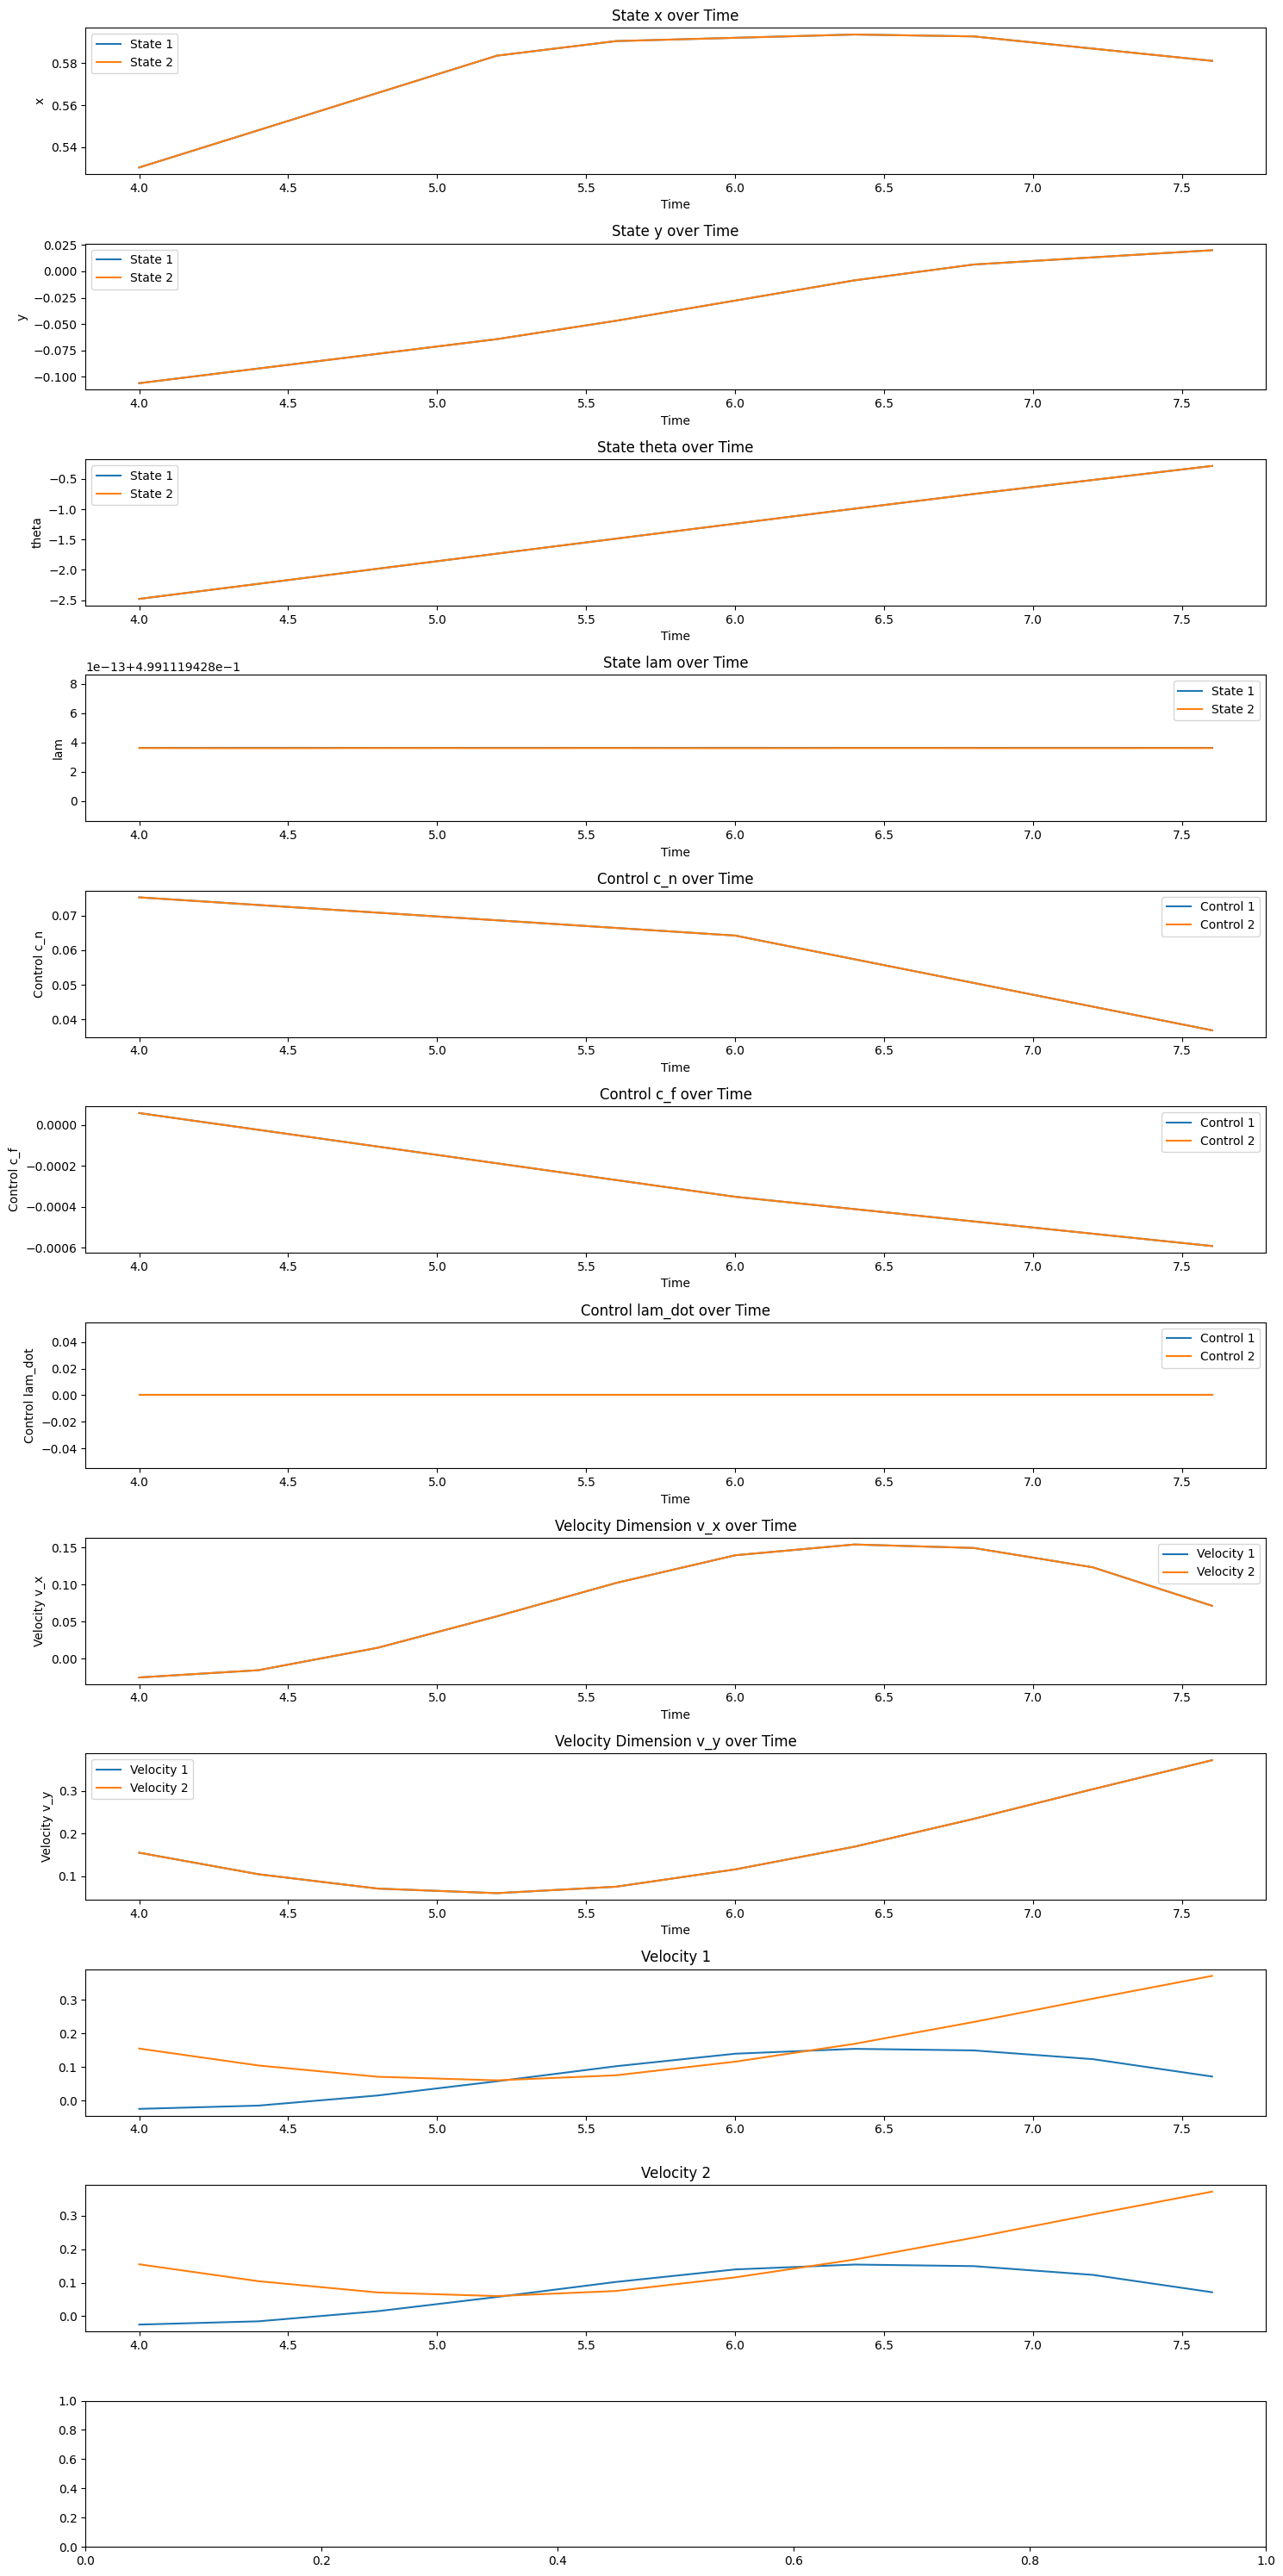

In [3]:
state_labels = ['x', 'y', 'theta', 'lam']
control_labels = ['c_n', 'c_f', 'lam_dot']
vel_labels = ['v_x', 'v_y']
# Create a figure with multiple subplots
fig, axs = plt.subplots(12, 1, figsize=(15, 30))

# Plotting each dimension of the state separately
for i in range(4):
    axs[i].plot(times, states_1[:, i], label=f'State 1')
    axs[i].plot(times, states_2[:, i], label=f'State 2')
    axs[i].set_title(f'State {state_labels[i]} over Time')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel(f'{state_labels[i]}')
    axs[i].legend()

# Plotting each dimension of the control separately
for i in range(3):
    axs[i+4].plot(times, controls_1[:, i], label=f'Control 1')
    axs[i+4].plot(times, controls_2[:, i], label=f'Control 2')
    axs[i+4].set_title(f'Control {control_labels[i]} over Time')
    axs[i+4].set_xlabel('Time')
    axs[i+4].set_ylabel(f'Control {control_labels[i]}')
    axs[i+4].legend()

# Plotting each dimension of the velocity separately
for i in range(2):
    axs[i+7].plot(times, desired_vels_1[:, i], label=f'Velocity 1')
    axs[i+7].plot(times, desired_vels_2[:, i], label=f'Velocity 2')
    axs[i+7].set_title(f'Velocity Dimension {vel_labels[i]} over Time')
    axs[i+7].set_xlabel('Time')
    axs[i+7].set_ylabel(f'Velocity {vel_labels[i]}')
    axs[i+7].legend()

for i in range(2):
    axs[9].plot(times, desired_vels_1[:,i])
    axs[10].plot(times, desired_vels_2[:,i])

axs[9].set_title(f"Velocity 1")
axs[10].set_title(f"Velocity 2")
plt.tight_layout()
plt.show()